In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import rbf_kernel 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
import time
from sklearn.calibration import calibration_curve
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ndcg_score
from sklearn.metrics import ndcg_score
from sklearn.metrics import top_k_accuracy_score
from ncon import ncon
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import warnings
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from sklearn.metrics import brier_score_loss
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
def effectivity_at_top_k(y_true, y_pred, k=1):
    return np.mean(y_true[np.argsort(y_pred)[::-1][:k]])

In [3]:
def outersum(a,b):
    return np.outer(a, np.ones(len(b))) + np.outer(np.ones(len(a)), b)

def outersum_deriv(a,b):
    return np.ones(len(a)), np.ones(len(b))

def maxoutersum(a,b,α):
    return np.log(outersum(np.exp(α*a), np.exp(α*b)))/α

def maxoutersum_deriv(a,b,α):
    D = 1./(outersum(np.exp(α*a), np.exp(α*b)))
    return (D.transpose()*np.exp(α*a)).transpose(), D*np.exp(α*b)

In [4]:
np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)

In [5]:
def pr_auc_score(true, pred, r=None):
    lr_precision, lr_recall, _ = precision_recall_curve(true, pred)
    if r is not None:
        r_ = (1/np.nanmean(true))-1  # ratio negatives/positives
        #print(r,r_)
        lr_precision = lr_precision/(lr_precision+r/r_*(1-lr_precision))
    return auc(lr_recall, lr_precision)

def metric_(true, pred, metric): #metrics such as auc throw error in case of one class available.
    if metric==ndcg_score:
        true=[true]
        pred=[pred]
    #return metric(true, pred)
    try:
        warnings.filterwarnings("ignore")
        return metric(true, pred)
    except:
        warnings.filterwarnings("default")
        return np.nan
def evaluate_per_row(true, pred, metric):
    return np.nanmean([metric_(true[i,:][~np.isnan(true[i,:])], pred[i,:][~np.isnan(true[i,:])],metric) for i in range(true.shape[0])])
def evaluate_per_column(true, pred, metric):
    return evaluate_per_row(true.transpose(), pred.transpose(), metric)


def evaluate_direct(Y_test, P):
    resprflat = []
    resprperrow = []
    resndcgperrow =[]
    for stage in range(4):
        true, pred = copy.deepcopy(Y_test[:,:,stage]), copy.deepcopy(P[:,:,stage])
        
        prflat = pr_auc_score(true[~np.isnan(true)], pred[~np.isnan(true)], r=30)
        resprflat.append(prflat)
    
    print("& {:.2} & {:.2} & {:.2} & {:.2}  \\\\".format(resprflat[0],resprflat[1],resprflat[2],resprflat[3]))
    
    return resprflat
    
def evaluate_conditional(Y_test, P):
    resprflat = []
    resprperrow = []
    resndcgperrow =[]    
    for stage in range(1,4):
        true, pred = copy.deepcopy(Y_test[:,:,stage]), copy.deepcopy(P[:,:,stage]/P[:,:,stage-1])
        prev = copy.deepcopy(Y_test[:,:,stage-1])
        
        true[prev==0]=np.nan
        pred[prev==0]=np.nan

        
        prflat = pr_auc_score(true[~np.isnan(true)], pred[~np.isnan(true)],r=30)
        resprflat.append(prflat)
        
    print("& {:.2} & {:.2} & {:.2}  \\\\".format(resprflat[0],resprflat[1],resprflat[2]))
    
    return [np.nan] + resprflat
    
        

In [6]:
def visualizeprogression(m, Ltrain, Lval, R):
    global Iter
    try:
        m.neval.append(m.neval[-1]+1)
        m.niter.append(Iter)
        m.Ltrain.append(Ltrain)
        m.R.append(R)
        m.Lval.append(Lval)
        
    except:
        # for the first loss evaluation. First evaluation corresponds loss after 0 iterations. After that. Iter is set to 1.
        m.Ltrain.append(Ltrain)
        m.R.append(R)
        m.Lval.append(Lval)
        
        Iter=0
        m.niter.append(Iter)
        Iter=1
        m.neval.append(1) 
    
    plt.figure()
    xx = pd.DataFrame()
    xx['niter']=np.array(m.niter)
    xx['norm']=np.array(m.R)
    xx['Lval']=np.array(m.Lval)
    xx['Ltrain'] = m.Ltrain
    xx = xx.groupby('niter', as_index=False).min() #if multiple function evaluations at same iteration
    plt.plot(xx.niter, xx.Ltrain/xx.Ltrain[0], label='L',c='k')
    plt.plot(xx.niter, xx.Lval/xx.Lval[0], label='Lval',c='k',linestyle='dashed')
    try:
        plt.plot(xx.niter, xx.norm/xx.norm[len(xx.norm)-1], label='norm')
    except:
        print(xx.norm)
    plt.legend()
    plt.yscale("log")
    plt.xscale("log")
    plt.savefig('optimization_termination')
    plt.close()
    
    print(Iter, Ltrain, R, Lval)

In [7]:
# x is logit, z is label
def sigmoidcrossentropy(x,z):#,β):
    #x = β*x
    ma = np.zeros(x.shape)
    ma[x>0]=x[x>0]
    return ma - x*z + np.log(1+np.exp(-abs(x)))
def sigmoidcrossentropy_deriv(x,z):#,β):
    #x = β*x
    res = np.zeros(x.shape)
    res[x>=0] = (1 - z - 1./(1+np.exp(-x))*np.exp(-x))[x>=0]
    res[x<0] = (-z + 1/(1+np.exp(x))*np.exp(x))[x<0]
    return res
def Epos(f, θ=1):
    res =  np.log(1+np.exp(θ*f))/θ
    res[(θ*f)>100]=f[(θ*f)>100]   #if overflow
    return res
def Epos_deriv(f, θ=1):
    res = np.exp(θ*f)/(1+np.exp(θ*f))
    res[(θ*f)>100]=1  #if overflow
    return res

def expcrossentropy(f,y):#,β):
    #f = β*f
    f=f+1e-15
    assert f.all()>0
    return y*f -(1-y)*np.log(1-np.exp(-f))

def expcrossentropy_deriv(f,y):#,β):
    #f = β*f
    f=f+1e-15
    assert f.all()>0
    return y - (1-y)/(1-np.exp(-f))*np.exp(-f)

def crossentropy(f,y):
    return np.nansum(-y*np.log(f+1e-15) - (1-y)*np.log(1-f+1e-15))

In [8]:
def predict(A, th1, th2, α,β, K1, K2, directsum=False):
    if directsum:
        f = β*(np.matmul(np.matmul(K1, A),K2.transpose()) + outersum(th1, th2))
    else:
        f = β*(np.matmul(np.matmul(K1, A),K2.transpose()) + maxoutersum(th1, th2, α))
    return f

def loss_deriv_(A_,K1,K2,Ytrain,Yval, m):
    if m.version == sigmoidcrossentropy:
        A = A_[:m.A.size].reshape(m.A.shape)
        th1 = A_[m.A.size:m.A.size+m.th1.size].reshape(m.th1.shape)
        th2 = A_[m.A.size+m.th1.size:m.A.size+m.th1.size+m.th2.size].reshape(m.th1.shape)
        β =  A_[m.A.size+m.th1.size+m.th2.size:]
        #f = predict(A, th1, th2, m.α, K1, K2)
        E = np.zeros(Ytrain.shape)
        for stage in range(E.shape[2]):
            E[:,:,stage] =predict(A[:,:,stage], th1[:,stage], th2[:,stage],m.α,β[stage],K1, K2, m.directsum)
        Ep = Epos(E)
        F = np.cumsum(Ep, axis=2)

        DLDF = (np.nan_to_num(sigmoidcrossentropy_deriv(F,Ytrain), nan=0)/len(np.where(~np.isnan(Ytrain))[0])) #if no label is nan, contribution to deriv is zero
        #DLDEp = np.cumsum(np.flip(DLDF,axis=2),axis=2)
        DLDEp = np.flip(np.cumsum(np.flip(DLDF,axis=2),axis=2),axis=2)
        DLDE = DLDEp*Epos_deriv(E)
                
        DLDA = np.zeros(A.shape)
        DLDTH1 = np.zeros(th1.shape)
        DLDTH2 = np.zeros(th1.shape)
        DLDβ = np.zeros(β.shape)
        for stage in range(E.shape[2]):
            DLDA[:,:,stage] = β[stage]*np.matmul(np.matmul(K1.transpose(), DLDE[:,:,stage]), K2)
            if m.directsum:
                DLDTH1[:,stage] = β[stage]*np.sum(DLDE[:,:,stage]*outersum_deriv(th1[:,stage],th2[:,stage],m.α)[0], axis=1)
                DLDTH2[:,stage] = β[stage]*np.sum(DLDE[:,:,stage]*outersum_deriv(th1[:,stage],th2[:,stage],m.α)[1], axis=0)
            else:
                DLDTH1[:,stage] = β[stage]*np.sum(DLDE[:,:,stage]*maxoutersum_deriv(th1[:,stage],th2[:,stage],m.α)[0], axis=1)
                DLDTH2[:,stage] = β[stage]*np.sum(DLDE[:,:,stage]*maxoutersum_deriv(th1[:,stage],th2[:,stage],m.α)[1], axis=0)
            if m.varβ:
                DLDβ[stage] = np.sum(DLDE[:,:,stage]*E[:,:,stage]/β[stage])
        DRDA = m.λ*2*A/A.size

        if m.competition:
            return np.concatenate([(DLDA+DRDA).flatten(),DLDTH1.flatten(), DLDTH2.flatten(),DLDβ])
        else:
            return np.concatenate([(DLDA+DRDA).flatten(),np.zeros(DLDTH1.size), np.zeros(DLDTH2.size),DLDβ])
        #DLDF = np.nan_to_num(sigmoidcrossentropy_deriv(f,Ytrain,m.β), nan=0)/len(np.where(~np.isnan(Ytrain))[0]) #if no label is nan, contribution to deriv is zero
    
    elif m.version ==  expcrossentropy:
        A = A_[:m.A.size].reshape(m.A.shape)
        th1 = A_[m.A.size:m.A.size+m.th1.size].reshape(m.th1.shape)
        th2 = A_[m.A.size+m.th1.size:m.A.size+m.th1.size+m.th2.size].reshape(m.th2.shape)
        β =  A_[m.A.size+m.th1.size+m.th2.size:]
        #f = predict(A, th1, th2, m.α, K1, K2)
        E = np.zeros(Ytrain.shape)
        for stage in range(E.shape[2]):
            E[:,:,stage] =predict(A[:,:,stage], th1[:,stage], th2[:,stage],m.α,β[stage],K1, K2, m.directsum)
        Ep = Epos(E)
        F = np.cumsum(Ep, axis=2)

        DLDF = (np.nan_to_num(expcrossentropy_deriv(F,Ytrain), nan=0)/len(np.where(~np.isnan(Ytrain))[0])) #if no label is nan, contribution to deriv is zero
        #DLDEp = np.cumsum(np.flip(DLDF,axis=2),axis=2)
        DLDEp = np.flip(np.cumsum(np.flip(DLDF,axis=2),axis=2),axis=2)
        DLDE = DLDEp*Epos_deriv(E)
                
        DLDA = np.zeros(A.shape)
        DLDTH1 = np.zeros(th1.shape)
        DLDTH2 = np.zeros(th2.shape)
        DLDβ = np.zeros(β.shape)
        for stage in range(E.shape[2]):
            DLDA[:,:,stage] = β[stage]*np.matmul(np.matmul(K1.transpose(), DLDE[:,:,stage]), K2)
            if m.directsum:
                DLDTH1[:,stage] = β[stage]*np.sum(DLDE[:,:,stage]*outersum_deriv(th1[:,stage],th2[:,stage],m.α)[0], axis=1)
                DLDTH2[:,stage] = β[stage]*np.sum(DLDE[:,:,stage]*outersum_deriv(th1[:,stage],th2[:,stage],m.α)[1], axis=0)
            else:
                DLDTH1[:,stage] = β[stage]*np.sum(DLDE[:,:,stage]*maxoutersum_deriv(th1[:,stage],th2[:,stage],m.α)[0], axis=1)
                DLDTH2[:,stage] = β[stage]*np.sum(DLDE[:,:,stage]*maxoutersum_deriv(th1[:,stage],th2[:,stage],m.α)[1], axis=0)
            if m.varβ:
                DLDβ[stage] = np.sum(DLDE[:,:,stage]*E[:,:,stage]/β[stage])
        DRDA = m.λ*2*A/A.size

        if m.competition:
            return np.concatenate([(DLDA+DRDA).flatten(),DLDTH1.flatten(), DLDTH2.flatten(),DLDβ])
        else:
            return np.concatenate([(DLDA+DRDA).flatten(),np.zeros(DLDTH1.size), np.zeros(DLDTH2.size),DLDβ])
    else:
        print('not implemented')
        return 'not implemented'

    
def loss_(A_,K1,K2,Ytrain,Yval, m):
    if m.version == sigmoidcrossentropy:
        A = A_[:m.A.size].reshape(m.A.shape)
        th1 = A_[m.A.size:m.A.size+m.th1.size].reshape(m.th1.shape)
        th2 = A_[m.A.size+m.th1.size:m.A.size+m.th1.size+m.th2.size].reshape(m.th1.shape)
        β =  A_[m.A.size+m.th1.size+m.th2.size:]
        #f = predict(A, th1, th2, m.α, K1, K2)
        E = np.zeros(Ytrain.shape)
        for stage in range(E.shape[2]):
            E[:,:,stage] = predict(A[:,:,stage], th1[:,stage], th2[:,stage],m.α, β[stage],K1, K2,m.directsum)
        Ep = Epos(E)
        F = np.cumsum(Ep, axis=2)
        
        L_train = np.nanmean(sigmoidcrossentropy(F, Ytrain)) #nan if label is not training label        
        L_val = np.nanmean(sigmoidcrossentropy(F, Yval))
        R = m.λ*np.sum(A*A)/A.size

        m.A[:]=A[:] 
        m.th1[:]=th1[:]
        m.th2[:]=th2[:]
        m.β[:]=β
        visualizeprogression(m, L_train, L_val, R)

        return L_train + R
        #L_train = np.nanmean(sigmoidcrossentropy(f, Ytrain,m.β)) #nan if label is not training label
        #L_val = np.nanmean(sigmoidcrossentropy(f, Yval,m.β))

    elif m.version ==  expcrossentropy:
        A = A_[:m.A.size].reshape(m.A.shape)
        th1 = A_[m.A.size:m.A.size+m.th1.size].reshape(m.th1.shape)
        th2 = A_[m.A.size+m.th1.size:m.A.size+m.th1.size+m.th2.size].reshape(m.th2.shape)
        β =  A_[m.A.size+m.th1.size+m.th2.size:]
        #f = predict(A, th1, th2, m.α, K1, K2)
        E = np.zeros(Ytrain.shape)
        for stage in range(E.shape[2]):
            E[:,:,stage] = predict(A[:,:,stage], th1[:,stage], th2[:,stage],m.α, β[stage],K1, K2, m.directsum)
        Ep = Epos(E)
        F = np.cumsum(Ep, axis=2)
        
        L_train = np.nanmean(expcrossentropy(F, Ytrain)) #nan if label is not training label        
        L_val = np.nanmean(expcrossentropy(F, Yval))
        R = m.λ*np.sum(A*A)/A.size

        m.A[:]=A[:] 
        m.th1[:]=th1[:]
        m.th2[:]=th2[:]
        m.β[:]=β
        visualizeprogression(m, L_train, L_val, R)

        return L_train + R
    else:
        print('not implemented')
        return 'not implemented'

def callback(A):
    global Iter
    Iter+=1

Iter=0

class Model_():
    def __init__(self, λ, competition, version, α, varβ, directsum):
        self.λ=λ
        self.A=0
        self.competition=competition
        self.version=version
        self.α=α
        self.varβ=varβ
        self.directsum = directsum
        self.neval, self.niter, self.Ltrain,self.R,self.Lval= [],[],[],[],[]
        global Iter
        Iter = 0

        
    
    def fit(self,K1,K2,Ytrain,Yval=None, maxiter=20):
        if type(self.A) != int:
            global Iter
            Iter = self.niter[-1]
            print("Continuing with current model parameters.")
            #res = minimize(fun=loss,x0=np.concatenate([self.A.flatten(), self.th1.flatten(), self.th2.flatten()]), args=(K1,K2,Ytrain,Yval,self), jac=loss_deriv, method='L-BFGS-B', options ={'maxiter':maxiter,'ftol': 0, 'gtol': 0}, callback=callback)
        else:
            A0=np.zeros((K1.shape[1], K2.shape[1],Ytrain.shape[2]))
            th1 = np.zeros((K1.shape[0],Ytrain.shape[2]))
            th2 = np.zeros((K2.shape[0],Ytrain.shape[2]))
            β = np.ones(Ytrain.shape[2])
            self.A=A0
            self.th1 = th1
            self.th2 = th2
            self.β=β
            print("New model parameters initialized as zeros.")

        res = minimize(fun=loss_,x0=np.concatenate([self.A.flatten(), self.th1.flatten(), self.th2.flatten(),self.β]), args=(K1,K2,Ytrain,Yval,self), jac=loss_deriv_, method='L-BFGS-B', options ={'maxiter':maxiter,'ftol': 0, 'gtol': 0}, callback=callback)
        A_ = res.x
        self.A = A_[:self.A.size].reshape(self.A.shape)
        self.th1 = A_[self.A.size:self.A.size+self.th1.size].reshape(self.th1.shape)
        self.th2 = A_[self.A.size+self.th1.size:self.A.size+self.th1.size+self.th2.size].reshape(self.th2.shape)
        self.β = A_[self.A.size+self.th1.size+self.th2.size:]
        return res
        
    def predict_proba(self, K1,K2,th=True):
        if self.version == sigmoidcrossentropy:
            E = np.zeros((K1.shape[0],K2.shape[0],self.A.shape[2]))
            for stage in range(E.shape[2]):
                E[:,:,stage] = predict(self.A[:,:,stage], self.th1[:,stage], self.th2[:,stage],self.α,self.β[stage], K1, K2)
            Ep = Epos(E)
            F = np.cumsum(Ep, axis=2)
            return 1 / (1 + np.exp(-F))
        elif self.version ==  expcrossentropy:
            E = np.zeros((K1.shape[0],K2.shape[0],self.A.shape[2]))
            for stage in range(E.shape[2]):
                E[:,:,stage] = predict(self.A[:,:,stage], self.th1[:,stage], self.th2[:,stage],self.α,self.β[stage], K1, K2)
            Ep = Epos(E)
            F = np.cumsum(Ep, axis=2)
            return np.exp(-F)
        else:
            print('not implemented')
            return 'not implemented'

    


In [10]:
def folds(Y, n_splits):
    idx1, idx2, idx3 = np.where(Y[:,:,:,0]) #folds the same for every stage, stages sliced at zero
    train_folds = []
    test_folds = []
    skf = StratifiedKFold(n_splits=n_splits, random_state=2, shuffle=True)
    for train_index, test_index in skf.split(range(len(idx1)),idx3): #stratify on terminator idx3
        train_folds.append([idx1[train_index], idx2[train_index], idx3[train_index]])
        test_folds.append([idx1[test_index], idx2[test_index], idx3[test_index]])
    return train_folds, test_folds
def to_pairwise_combinations(Y, K_i, K_c, K_t):
    Ypairwise = Y.reshape((Y.shape[0]*Y.shape[1], Y.shape[2], Y.shape[3]))
    K_ic = np.kron(K_i, K_c)
    return Ypairwise, K_ic, K_t
        

In [11]:
keepinds = [1,0,2,3,8] # the terminators to model

Y = np.load("../DataPreprocessing/termination_Y.npy")[:,:,keepinds,:]
# kernels based on sequences, did not work very well
#K_i = np.load("../DataPreprocessing/termination_Ki.npy")
#K_c = np.load("../DataPreprocessing/termination_Kc.npy")
#K_t = np.load("../DataPreprocessing/termination_Kt.npy")[keepinds,:][:, keepinds]

# the modifiers, spacers, and terminators
I = np.array(pd.read_csv('../DataPreprocessing/i', header=None))[:,0]
C = np.array(pd.read_csv('../DataPreprocessing/c', header=None))[:,0]
T = np.array(pd.read_csv('../DataPreprocessing/t', header=None))[:,0][keepinds]
tseq = pd.read_csv('../DataPreprocessing/tseq', header=None).iloc[keepinds]

# up till now, the windows are of length 45. Now, we select windows of length 15, by defining its end nucleotide
ends=np.array([35, 29, 35, 35,39,35,35])
l = 15
Y_ = copy.deepcopy(Y[:,:,:,:l])
for i in range(Y.shape[2]):
    Y_[:,:,i,:] = Y[:,:,i,ends[i]-l:ends[i]]
    tseq.iloc[i,0] = tseq.iloc[i,0][ends[i]-l:ends[i]]
Y = Y_

In [14]:
Y.shape,  T

((13, 7, 5, 15), array(['T12', 'T10', 'T13', 'T14', 'T20'], dtype=object))

In [15]:
np.array(pd.read_csv('../DataPreprocessing/t', header=None))[:,0]

array(['T10', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18', 'T20',
       'T21', 'T27', 'T29', 'T33'], dtype=object)

In [16]:
def make_conditional(a):
    res = np.ones(len(a))
    for i in range(1,len(a)):
        res[i] = a[i]/a[i-1]
    return res

def make_conditional_(a):
    res = np.ones(a.shape)
    for i in range(1,a.shape[-1]):
        res[:,:,i] = a[:,:,i] / a[:,:,i-1]
    return res

def make_conditional__(a):
    res = np.ones(a.shape)
    for i in range(1,a.shape[-1]):
        res[:,:,:,i] = a[:,:,:,i] / a[:,:,:,i-1]
    return res

def rbf(a,b,r): #50
    d = a-b
    d = d[~np.isnan(d)]
    return np.exp(-r* np.sum(d**2) /  len(d) )

def cos_(a,b,r): #50
    prod = a*b
    n1 = np.sqrt(np.sum(a[~np.isnan(prod)]**2))
    n2 = np.sqrt(np.sum(b[~np.isnan(prod)]**2))
    dot = np.nansum(prod)
    return dot / n1 / n2

def crossentropy_(a,b):
    return np.nansum(crossentropy(a,b)) + np.nansum(crossentropy(b,a))

# different attempts on kernels based on the training labels as features: also did not work very well
def K_terminationprofile(Y_train, metric, cond, r):
    K = np.nan*np.ones((Y_train.shape[2], Y_train.shape[2]))
    for i in range(Y_train.shape[2]):
        for j in range(Y_train.shape[2]):
            if cond==False:
                K[i,j] = metric(Y_train[:,:,i,:].flatten(), Y_train[:,:,j,:].flatten(),r)
            else:
                K[i,j] = metric(make_conditional_(Y_train[:,:,i,:]).flatten(), make_conditional_(Y_train[:,:,j,:]).flatten(),r)
    return (K - np.min(K)) / (np.max(K) - np.min(K))

def K_ilabel(Y_train, metric, cond, r):
    K = np.nan*np.ones((Y_train.shape[0], Y_train.shape[0]))
    for i in range(Y_train.shape[0]):
        for j in range(Y_train.shape[0]):
            if cond==False:
                K[i,j] = metric(Y_train[i,:,:,:].flatten(), Y_train[j,:,:,:].flatten(),r)
            else:
                K[i,j] = metric(make_conditional_(Y_train[i,:,:,:]).flatten(), make_conditional_(Y_train[j,:,:,:]).flatten(),r)
    return (K - np.min(K)) / (np.max(K) - np.min(K))

def K_clabel(Y_train, metric, cond, r):
    K = np.nan*np.ones((Y_train.shape[1], Y_train.shape[1]))
    for i in range(Y_train.shape[1]):
        for j in range(Y_train.shape[1]):
            if cond==False:
                K[i,j] = metric(Y_train[:,i,:,:].flatten(), Y_train[:,j,:,:].flatten(),r)
            else:
                K[i,j] = metric(make_conditional_(Y_train[:,i,:,:]).flatten(), make_conditional_(Y_train[:,j,:,:]).flatten(),r)
    return (K - np.min(K)) / (np.max(K) - np.min(K))

In [17]:
Y.shape

(13, 7, 5, 15)

In [18]:
cs = ['b', 'y', 'r', 'k', 'c']

In [19]:
# final experiments that works: run with smoothing kernels
def run_alldiag(n_iter = 100, λ=1e0, smo=(0.1,0.1,0.1)):
    Y_train_pred = np.nan*Y
    Y_test_pred = np.nan*Y

    ni,nc,nt,profile_length = Y.shape
    for i in range(n_splits):
        idx1_train, idx2_train, idx3_train = train_folds[i]
        idx1_test, idx2_test, idx3_test = test_folds[i]

        Y_train = copy.deepcopy(Y)
        Y_test = copy.deepcopy(Y)
        Y_train[idx1_test, idx2_test, idx3_test] = np.nan
        Y_test[idx1_train, idx2_train, idx3_train] = np.nan
        print(np.sum(~np.isnan(Y_train))/profile_length , np.sum(~np.isnan(Y_test))/profile_length)
        print((np.sum(~np.isnan(Y_train)) + np.sum(~np.isnan(Y_test)))/profile_length)

        K_i = np.load("../DataPreprocessing/termination_Ki.npy")
        K_c = np.load("../DataPreprocessing/termination_Kc.npy")
        K_t = np.load("../DataPreprocessing/termination_Kt.npy")[keepinds,:][:, keepinds]
        K_i = (np.diag(np.ones(len(K_i))) + smo[0]* np.ones(K_i.shape)) / (1+smo[0])
        K_c = (np.diag(np.ones(len(K_c))) + smo[1]* np.ones(K_c.shape)) / (1+smo[1])
        K_t = (np.diag(np.ones(len(K_t))) + smo[2]* np.ones(K_t.shape)) / (1+smo[2])
        Ypairwise_train, K_ic, K_t = to_pairwise_combinations(Y_train, K_i, K_c, K_t)
        Ypairwise_test, K_ic, K_t = to_pairwise_combinations(Y_test, K_i, K_c, K_t)

        model1_=Model_(λ=λ, competition=False, version=expcrossentropy,α=1, varβ=False, directsum=False)
        res = model1_.fit(K_ic,K_t,Ypairwise_train,Ypairwise_test,maxiter=n_iter)

        YPairwise_pred = model1_.predict_proba(K_ic,K_t)
        Y_pred = YPairwise_pred.reshape(Y.shape)

        print(len(idx1_train), len(idx1_test))
        Y_train_pred[idx1_train, idx2_train, idx3_train]=Y_pred[idx1_train, idx2_train, idx3_train]
        Y_test_pred[idx1_test, idx2_test, idx3_test] = Y_pred[[idx1_test, idx2_test, idx3_test]]
    return Y_train_pred, Y_test_pred    

In [20]:
n_splits=5
train_folds, test_folds = folds(Y, n_splits=n_splits)

In [21]:
#smo=(0.3,0.3,0) : smoothing for terminators is 0, such that they are considered as independet data sets

Y_train_pred_alldiagt0, Y_test_pred_alldiagt0 = run_alldiag(n_iter = 50, λ=0,smo=(0.3,0.3,0))

363.0 91.0
454.0
New model parameters initialized as zeros.


/opt/Anaconda3/envs/vdab/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


1 5.652161582079972 0.0 5.701651231325269
1 5.211227715834688 0.0 5.265668050881342
1 3.6996971454805387 0.0 3.766021174617199
2 0.9433747738894789 0.0 0.9806722650744929
3 0.6130507791148473 0.0 0.6340640453231743
4 0.46195675626176225 0.0 0.4677601345427045
5 0.43256861328162194 0.0 0.4318388006936545
6 0.42281241102877737 0.0 0.41964352475291467
7 0.414755188224858 0.0 0.4114913210156262
8 0.41241102104531036 0.0 0.40770166130224283
9 0.4097232173383205 0.0 0.4066114777210118
10 0.4091934307006604 0.0 0.40587075755127516
11 0.40763615614551274 0.0 0.4037923050820636
12 0.4068569658763076 0.0 0.40315349628378094
13 0.40647654848531856 0.0 0.40274807381127214
14 0.4063260249650354 0.0 0.40278474030058886
15 0.4061586512088931 0.0 0.402789190939732
16 0.40587701911079976 0.0 0.4028026021313451
17 0.40563303464264455 0.0 0.40279411755142436
18 0.4054092371253735 0.0 0.40270002896685275
19 0.40520411311176496 0.0 0.4024768905203233
20 0.4050625101528774 0.0 0.402362753333867
21 0.4049140

/opt/Anaconda3/envs/vdab/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/opt/Anaconda3/envs/vdab/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


1 5.679632709840844 0.0 5.592068600806626
1 5.236620123624341 0.0 5.165498721453763
1 3.7179335755353753 0.0 3.696609080304434
2 0.9464140336146931 0.0 0.9645513615666302
3 0.6137901437975392 0.0 0.6273831364774288
4 0.4611437258443165 0.0 0.46821399000586106
5 0.4311911386822345 0.0 0.4351613862164918
6 0.4213787846983546 0.0 0.42415537379528545
7 0.4133863605612085 0.0 0.41562544555812714
8 0.41096294601669314 0.0 0.4152980386937973
9 0.40827812446981504 0.0 0.4105337374587621
10 0.4077497027288385 0.0 0.4100656895773472
11 0.4065123212432594 0.0 0.4088125218954739
12 0.40556968268313015 0.0 0.4077401947119056
13 0.40510763138593947 0.0 0.4073787417257333
14 0.4048641847812886 0.0 0.4070218300731633
15 0.40471992949588864 0.0 0.40690808483313207
16 0.40441514119740185 0.0 0.40675501638736894
17 0.40412207982201537 0.0 0.40675545638780736
18 0.40386930367283863 0.0 0.40676408179075757
19 0.4036865399696165 0.0 0.4067332493204785
20 0.40349150627613173 0.0 0.4068030091150957
21 0.40333

/opt/Anaconda3/envs/vdab/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/opt/Anaconda3/envs/vdab/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


1 5.648874799694548 0.0 5.71476224237921
1 5.208033577016479 0.0 5.278579510592808
1 3.69696393453026 0.0 3.777867211185376
2 0.9422295106547708 0.0 0.9880148557334459
3 0.6115216060861707 0.0 0.6402509877179979
4 0.46011840309665225 0.0 0.4735281459671961
5 0.43041166206419657 0.0 0.4379340121774531
6 0.42033193639074695 0.0 0.42652481886749843
7 0.4120447431911816 0.0 0.42045192440366924
8 0.4098442058729991 0.0 0.41877773235104887
9 0.4070218539242822 0.0 0.41559657946546125
10 0.40653049607666353 0.0 0.4149305290580743
11 0.40512892879377793 0.0 0.4129562649988322
12 0.4045161795132903 0.0 0.413026431614228
13 0.40399034690219016 0.0 0.4120227663365611
14 0.4038476250137031 0.0 0.4119664269605092
15 0.4036919740837423 0.0 0.4120083164418272
16 0.40337556361311244 0.0 0.4120976454240476
17 0.4031032299658655 0.0 0.4123409646979419
18 0.40286955041359257 0.0 0.4122550717421649
19 0.4026821013795968 0.0 0.4119293437556823
20 0.4025202821266058 0.0 0.4117821151874131
21 0.4023601426160

/opt/Anaconda3/envs/vdab/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/opt/Anaconda3/envs/vdab/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


1 5.676132095018402 0.0 5.6052537084325635
1 5.233805791467321 0.0 5.174780989342522
1 3.716925919188051 0.0 3.6943786052822922
2 0.9449126319963079 0.0 0.9584340072676353
3 0.6129845040956059 0.0 0.6244357988224083
4 0.46045784832898073 0.0 0.46860478524559634
5 0.4304855146285997 0.0 0.4372156614459797
6 0.4205594514074502 0.0 0.4271850622031781
7 0.41260555610800714 0.0 0.4192458164076192
8 0.41029431907141584 0.0 0.41592871289123295
9 0.4075029756594475 0.0 0.4147298422993972
10 0.40697530213042693 0.0 0.4141094884045348
11 0.4055574373361961 0.0 0.4126198336554762
12 0.4046066654705645 0.0 0.4115609114756247
13 0.4041375952080774 0.0 0.4115420297250303
14 0.40395294228590606 0.0 0.41147766061311425
15 0.4037552586637083 0.0 0.4113607768475202
16 0.40347591087748885 0.0 0.4111630129682
17 0.4032009794850356 0.0 0.41107173422330395
18 0.4029331212458181 0.0 0.4109496138835337
19 0.4027134681261657 0.0 0.4110003109177393
20 0.40252478866374847 0.0 0.4111363355896967
21 0.402400726037

/opt/Anaconda3/envs/vdab/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/opt/Anaconda3/envs/vdab/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


1 5.653566673662373 0.0 5.696046305562505
1 5.212698097925079 0.0 5.260017121595008
1 3.7010742866047535 0.0 3.760107022226015
2 0.9424557752972482 0.0 0.9795896678476452
3 0.6123357520062435 0.0 0.6351157733049464
4 0.46106507052549844 0.0 0.470726648212078
5 0.4314300231295069 0.0 0.4358760382036629
6 0.4215113841188641 0.0 0.4244981492414817
7 0.4135149863101609 0.0 0.4160490468675675
8 0.4116460447571455 0.0 0.4156982541043099
9 0.4086715918964188 0.0 0.41119393480483646
10 0.4081607608696419 0.0 0.41059180634493486
11 0.40688836287114816 0.0 0.409213457753796
12 0.40608062566201336 0.0 0.4076126291845897
13 0.4055622391580948 0.0 0.4075073188588539
14 0.4054058037643062 0.0 0.40725577102720334
15 0.4052721753121407 0.0 0.4070529567764506
16 0.40504283069337177 0.0 0.4068338711048776
17 0.40476163346560895 0.0 0.4067008767017107
18 0.40455600838600403 0.0 0.4068138862150063
19 0.40436451746968205 0.0 0.40674031895062984
20 0.4042101957561193 0.0 0.4068226087166469
21 0.404097384495

/opt/Anaconda3/envs/vdab/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


## Per terminatorplot

In [22]:
def perterminatorplot(Y,Ypred):
    
    fig, ax = plt.subplots(1,5, figsize=(5*4,4),sharex=True,sharey=True)
    ax = ax.flatten()
    for i in range(Y.shape[2]):
        Te = Y[:,:,i,-1].flatten()
        Te_pred = Ypred[:,:,i,-1].flatten()
        Te_base = Ybase[:,:,i,-1].flatten()
        #plt.figure(figsize=(2,2))
        ax[i].set_xlim(0,1)
        ax[i].set_ylim(0,1)
        ax[i].scatter(Te, Te_pred,alpha=0.5, s=60)
        ax[i].plot([0,1],[0,1],'k')
        ax[i].set_title(T[i], fontsize=35)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        cor = np.corrcoef(Te[~np.isnan(Te)], Te_pred[~np.isnan(Te)])[0,1]
        r2 = r2_score(Te[~np.isnan(Te)], Te_pred[~np.isnan(Te)])
        BSS = 1 - mean_squared_error(Te[~np.isnan(Te)], Te_pred[~np.isnan(Te)]) / mean_squared_error(Te[~np.isnan(Te)], Te_base[~np.isnan(Te)])
        CE_compar = crossentropy(Te_pred[~np.isnan(Te)], Te[~np.isnan(Te)]) / crossentropy(Te_base[~np.isnan(Te)], Te[~np.isnan(Te)])
        ax[i].text(0.05, 0.85, r"$\rho$ :  {:.2f}".format(cor), fontsize=20,verticalalignment='top')
        #ax[i].text(0.05, 0.75, "CE compar:  {:.2f}".format(CE_compar), fontsize=10,verticalalignment='top')
        ax[i].text(0.05, 0.95, r"$R^2$ :  {:.2f}".format(r2), fontsize=20,verticalalignment='top')
    for i in range(Y.shape[2], len(ax)):
        ax[i].axis('off')
    fig.text(0.5, -0.05, r'$p_{ij}^{\mathrm{end}}$', ha='center', fontsize=30)
    fig.text(0.08, 0.5, r'$\hat{p}_{ij}^{\mathrm{end}}$', va='center', rotation='vertical', fontsize=30)
    plt.show()

In [23]:
Ybase = copy.deepcopy(Y)
for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
        for k in range(Y.shape[2]):
            for l in range(Y.shape[3]):
                Ybase[i,j,k,l] = np.nanmean(Y[:,:,k,l])

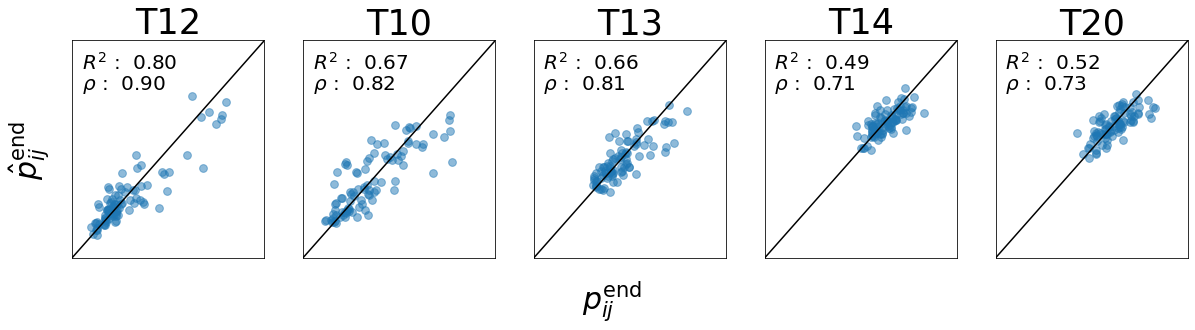

In [24]:
perterminatorplot(Y, Y_test_pred_alldiagt0)

## Per terminator and spacer

In [25]:
def perterminatorandspacerplot(Y,Ypred):
    fig, ax = plt.subplots(Y.shape[2],Y.shape[1], figsize=(1.5*7,1.5*5))
    for i in range(Y.shape[2]):
        for j in range(Y.shape[1]):
            Te = Y[:,j,i,-1].flatten()
            Te_pred = Ypred[:,j,i,-1].flatten()
            #plt.figure(figsize=(2,2))
            ax[i,j].set_xlim(0,1)
            ax[i,j].set_ylim(0,1)
            ax[i,j].scatter(Te, Te_pred,alpha=0.3)
            ax[i,j].plot([0,1],[0,1],'k')
            #ax[i,j].set_title(T[i])
            if j==0:
                ax[i,j].text(-0.6, 0.4, T[i], fontsize=15)
            if i==0:
                ax[i,j].text(0.3, 1.2, C[j], fontsize=15)
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            cor = np.corrcoef(Te[~np.isnan(Te)], Te_pred[~np.isnan(Te)])[0,1]
            r2 = r2_score(Te[~np.isnan(Te)], Te_pred[~np.isnan(Te)])
            ax[i,j].text(0.05, 0.85, "corr: {:.2f}".format(cor), fontsize=7,
                verticalalignment='top')
            ax[i,j].text(0.05, 0.95, "r2: {:.2f}".format(r2), fontsize=7,
                verticalalignment='top')
    plt.show()
    
def perterminatorandspacerplot_color(Y,Ypred):
    R = np.zeros((Y.shape[2],Y.shape[1]))
    for i in range(Y.shape[2]):
        for j in range(Y.shape[1]):
            Te = Y[:,j,i,-1].flatten()
            Te_pred = Ypred[:,j,i,-1].flatten()
            r = np.corrcoef(Te[~np.isnan(Te)], Te_pred[~np.isnan(Te)])[0,1]
            R[i,j] = r    
    plt.figure()
    plt.imshow(R)
    plt.colorbar()
    plt.show()

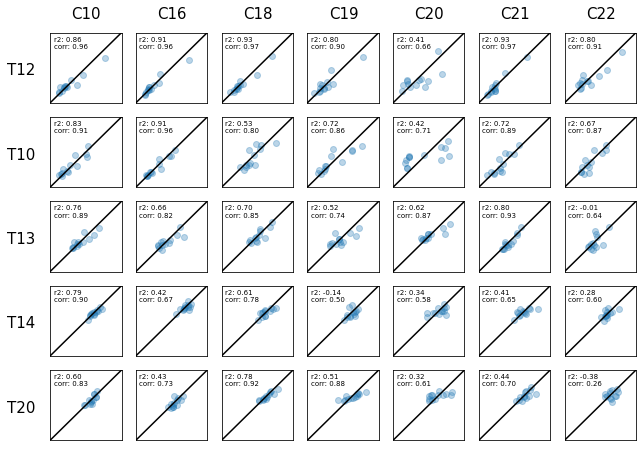

In [26]:
perterminatorandspacerplot(Y, Y_test_pred_alldiagt0)

## Per terminator and modifier

In [27]:
def perterminatorandmodifierplot(Y,Ypred):
    fig, ax = plt.subplots(Y.shape[2],Y.shape[0], figsize=(1.5*7,1.5*5))
    for i in range(Y.shape[2]):
        for j in range(Y.shape[0]):
            Te = Y[j,:,i,-1].flatten()
            Te_pred = Ypred[j,:,i,-1].flatten()
            #plt.figure(figsize=(2,2))
            ax[i,j].set_xlim(0,1)
            ax[i,j].set_ylim(0,1)
            ax[i,j].scatter(Te, Te_pred,alpha=0.3)
            ax[i,j].plot([0,1],[0,1],'k')
            #ax[i,j].set_title(T[i])
            if j==0:
                ax[i,j].text(-0.6, 0.4, T[i], fontsize=15)
            if i==0:
                ax[i,j].text(0.3, 1.2, I[j], fontsize=15)
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            cor = np.corrcoef(Te[~np.isnan(Te)], Te_pred[~np.isnan(Te)])[0,1]
            r2 = r2_score(Te[~np.isnan(Te)], Te_pred[~np.isnan(Te)])
            ax[i,j].text(0.05, 0.85, "corr: {:.2f}".format(cor), fontsize=7,
                verticalalignment='top')
            ax[i,j].text(0.05, 0.95, "r2: {:.2f}".format(r2), fontsize=7,
                verticalalignment='top')
    plt.show()
    

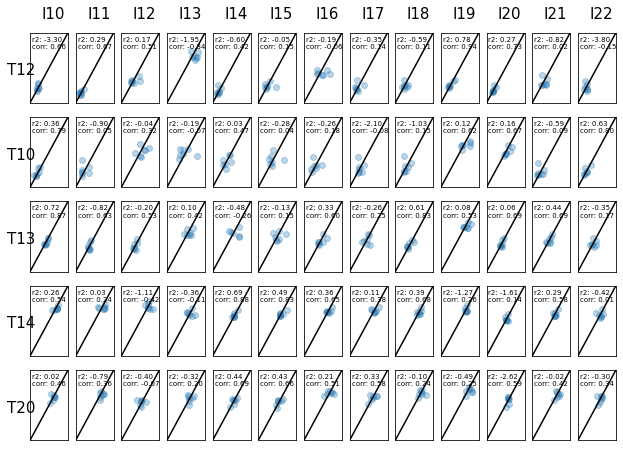

In [28]:
perterminatorandmodifierplot(Y,Y_test_pred_alldiagt0)

## Chain evaluation

## Monotonechainplot

In [29]:
def monotonechainplot_perterminator(Y,Ypred,terminator_idx,n,cond):
    #j,k = 0,0 #3,0
    k = terminator_idx
    #palette = sns.color_palette(None, Y.shape[0])
    for i in np.random.choice(Y.shape[0], n, replace=False):#range(Y.shape[0]):
        j = np.random.choice(Y.shape[1])
        if cond:
            plt.plot(make_conditional(Y[i,j,k,:]), c = palette[i])
            plt.plot(make_conditional(Ypred[i,j,k,:]), c = palette[i], linestyle='dotted')
        else:
            plt.plot(Y[i,j,k,:], c = palette[i])
            plt.plot(Ypred[i,j,k,:], c = palette[i], linestyle='dotted')
    plt.show()
 

    
def monotonechainplot_random(Y,Ypred,n,cond):
    #j,k = 0,0 #4,0
    #palette = sns.color_palette(None, Y.shape[0])
    for i_ in range(n):#Y.shape[0]):
        i,j,k = np.random.choice(Y.shape[0]), np.random.choice(Y.shape[1]), np.random.choice(Y.shape[2])
        if cond:
            plt.plot(make_conditional(Y[i,j,k,:]), c = palette[i],label=I[i]+' - '+C[j]+' - '+T[k])
            plt.plot(make_conditional(Ypred[i,j,k,:]), c = palette[i], linestyle='dotted')
        else:
            plt.plot(Y[i,j,k,:], c = palette[i],label=I[i]+' - '+C[j]+' - '+T[k])
            plt.plot(Ypred[i,j,k,:], c = palette[i], linestyle='dotted')
    plt.legend()
    plt.show()

In [30]:
palette = ['b', 'y', 'r', 'c', 'k']

In [31]:
#monotonechainplot_perterminatorandspacer(Y,Y_test_pred_alldiagt0,terminator_idx=1, spacer_idx = 0, n=5, cond=True, Is=[0,1,2,3])
#monotonechainplot_perterminatorandspacer(Y,Y_test_pred_alldiagt0,terminator_idx=2, spacer_idx = 0, n=5, cond=True, Is=[0,1,2,3])
#monotonechainplot_perterminatorandmodifier(Y,Y_test_pred_alldiagt0,terminator_idx=2, modifier_idx = 0, n=6, cond=True, Is=[0,1,2,3])
#monotonechainplot_perterminatorandmodifier(Y,Y_test_pred_alldiagt0,terminator_idx=0, modifier_idx = 0, n=6, cond=True, Is=[0,1,2,3])
#monotonechainplot_perterminatorandmodifier(Y,Y_test_pred_alldiagt0,terminator_idx=1, modifier_idx = 0, n=6, cond=True, Is=[0,1,2,3])
#monotonechainplot_perterminatorandspacer(Y,Y_test_pred_alldiagt0,terminator_idx=4, spacer_idx = 0, n=6, cond=True, Is=[0,1,2,3])

In [32]:
def monotonechainplot_perterminatorandmodifier(Y,Ypred,modifier_idx,terminator_idx,n,cond,Is=0):
    #j,k = 0,0 #3,0
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    i,k = modifier_idx,terminator_idx
    if Is==0:
        Is = np.random.choice(Y.shape[1], n, replace=False)
    print(Is)
    c=0
    for j in Is:#range(Y.shape[0]):
        ax[0].plot(make_conditional(Y[i,j,k,:]), c = palette[c],label=C[j] + " - " + I[i])
        ax[0].plot(make_conditional(Ypred[i,j,k,:]), c = palette[c], linestyle='dotted')
        
        ax[1].plot(Y[i,j,k,:], c = palette[c],label=C[j] + " - " + I[i])
        ax[1].plot(Ypred[i,j,k,:], c = palette[c], linestyle='dotted')
        
        ax[0].set_xticks(range(len(Y[i,j,k,:])))
        ax[0].set_xticklabels(range(1, 1+len(Y[i,j,k,:])))
        ax[1].set_xticks(range(len(Y[i,j,k,:])))
        ax[1].set_xticklabels(range(1, 1+len(Y[i,j,k,:])))
        
        ax[0].set_xlabel("nucleotide position")
        ax[1].set_xlabel("nucleotide position")
        ax[0].set_ylabel("transitional probability")
        ax[1].set_ylabel("marginal probability")
        c+=1

    
    plt.text(20,0.7, T[k], fontsize=30)
    plt.text(20,0.65, "constant modifier", fontsize=20)

    plt.legend(loc=(1.35,0.6), fontsize=12)
    plt.show()
    
def monotonechainplot_perterminatorandspacer(Y,Ypred,spacer_idx,terminator_idx,n,cond,Is=0):
    #j,k = 0,0 #3,0
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    j,k = spacer_idx,terminator_idx
    if Is==0:
        Is = np.random.choice(Y.shape[0], n, replace=False)
    print(Is)
    c=0
    for i in Is:#range(Y.shape[0]):
        ax[0].plot(make_conditional(Y[i,j,k,:]), c = palette[c], label=C[j] + " - " + I[i])
        ax[0].plot(make_conditional(Ypred[i,j,k,:]), c = palette[c], linestyle='dotted')
        
        ax[1].plot(Y[i,j,k,:], c = palette[c],label=C[j] + " - " + I[i])
        ax[1].plot(Ypred[i,j,k,:], c = palette[c], linestyle='dotted')
        
        ax[0].set_xticks(range(len(Y[i,j,k,:])))
        ax[0].set_xticklabels(range(1, 1+len(Y[i,j,k,:])))
        ax[1].set_xticks(range(len(Y[i,j,k,:])))
        ax[1].set_xticklabels(range(1, 1+len(Y[i,j,k,:])))
        
        ax[0].set_xlabel("nucleotide position")
        ax[1].set_xlabel("nucleotide position")
        ax[0].set_ylabel("transitional probability")
        ax[1].set_ylabel("marginal probability")
        
        c+=1
    
    plt.text(20,0.45, T[k], fontsize=30)
    plt.text(20,0.35, "constant spacer", fontsize=20)
    plt.legend(loc=(1.35,0.6), fontsize=12)
    plt.show()

In [33]:
C = [x.replace('C', 'S') for x in C]
I = [x.replace('I', 'M') for x in I]

[0, 1, 2, 3]


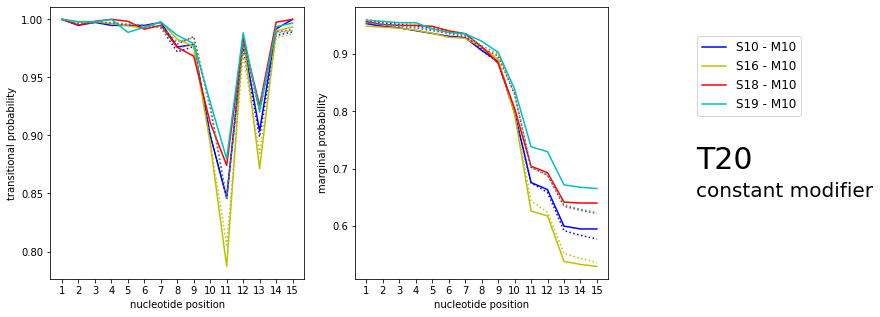

In [34]:
monotonechainplot_perterminatorandmodifier(Y,Y_test_pred_alldiagt0,terminator_idx=4, modifier_idx = 0, n=6, cond=True, Is=[0,1,2,3])

[0, 1, 2, 3]


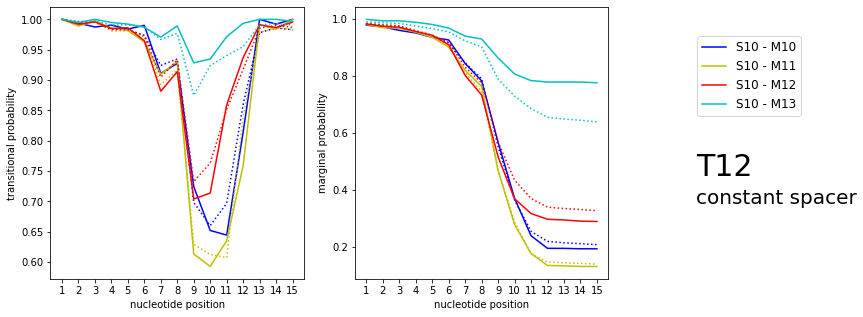

In [35]:
monotonechainplot_perterminatorandspacer(Y,Y_test_pred_alldiagt0,terminator_idx=0, spacer_idx = 0, n=5, cond=True, Is=[0,1,2,3])